In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
# !pip install -r requirements.txt

# Data: CelebA

## Dataset

In [3]:
from src.modules.celeba_data_module import CelebADataset, CelebA_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
labels_map = get_labels(config = config_celeba)

print('Number of class in label map', len(list(labels_map.keys())) )
# print()
# print('Number of samples per person')
# for i, (k, v) in enumerate(list(labels_map.items())):
#     print(len(v))
#     if i >5:
#         break
print('\ntesting dataset')

num_classes=100

dataset = CelebADataset(labels_map, num_classes=list(range(num_classes)))
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 2234
nb classes in dataloader 100


 Train dataset ----------------------------




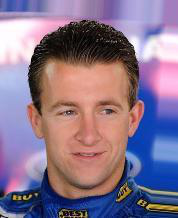

label 0
shape (178, 218)




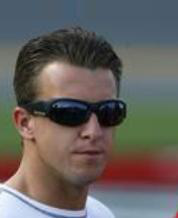

label 0
shape (178, 218)


In [4]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [5]:
import multiprocessing as mp
from src.modules.celeba_data_module import DATASETS

num_classes_iter = 4
batch_size = 16
dataloader = CelebA_DataModule(name=DATASETS.CELEBA, nb_classes=num_classes, class_split=True, batch_size = batch_size,
                               num_classes_iter=num_classes_iter, splitting_points=(0.10, 0.10),  
                               input_shape = (3, 256, 256), num_workers = mp.cpu_count())

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

split size 80 10 10
train classes 0 80
val classes 80 90
test classes 90 100
Number of train batches 109
Number of valid batches 8
Number of test batches 8


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(0), tensor(0), tensor(0), tensor(0)]
[tensor(55), tensor(55), tensor(55), tensor(55)]
[tensor(55), tensor(55), tensor(55), tensor(55)]
[tensor(36), tensor(36), tensor(36), tensor(36)]


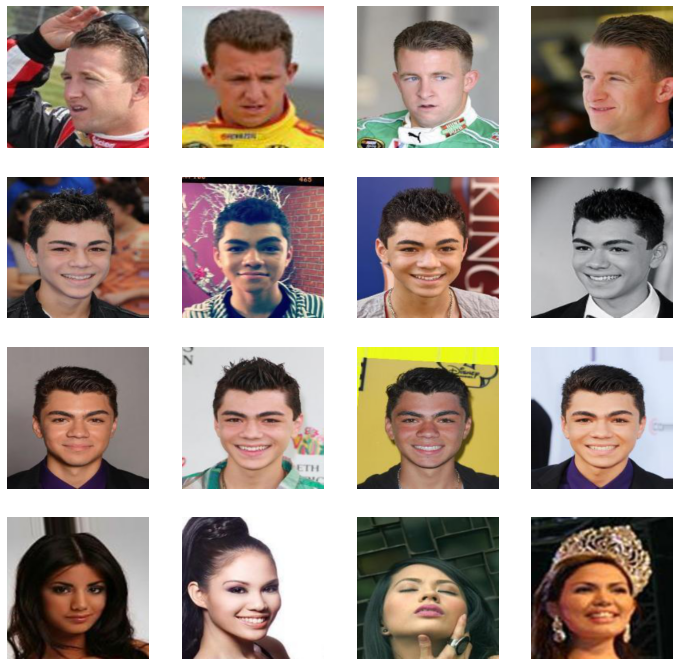

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(86), tensor(86), tensor(86), tensor(86)]
[tensor(87), tensor(87), tensor(87), tensor(87)]
[tensor(82), tensor(82), tensor(82), tensor(82)]
[tensor(87), tensor(87), tensor(87), tensor(87)]
[tensor(81), tensor(81), tensor(81), tensor(81)]
[tensor(84), tensor(84), tensor(84), tensor(84)]
[tensor(88), tensor(88), tensor(88), tensor(88)]
[tensor(84), tensor(84), tensor(84), tensor(84)]


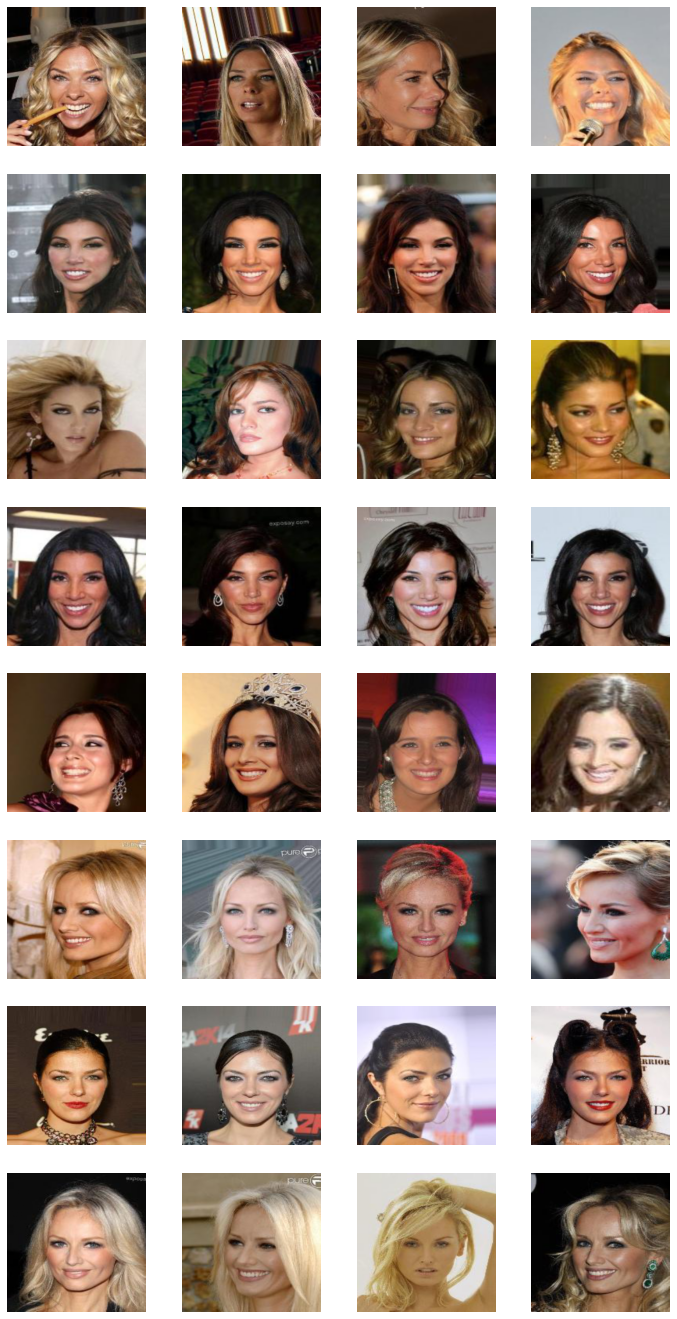

In [7]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(90), tensor(90), tensor(90), tensor(90)]
[tensor(90), tensor(90), tensor(90), tensor(90)]
[tensor(90), tensor(90), tensor(90), tensor(90)]
[tensor(90), tensor(90), tensor(95), tensor(95)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(95), tensor(95), tensor(95), tensor(95)]


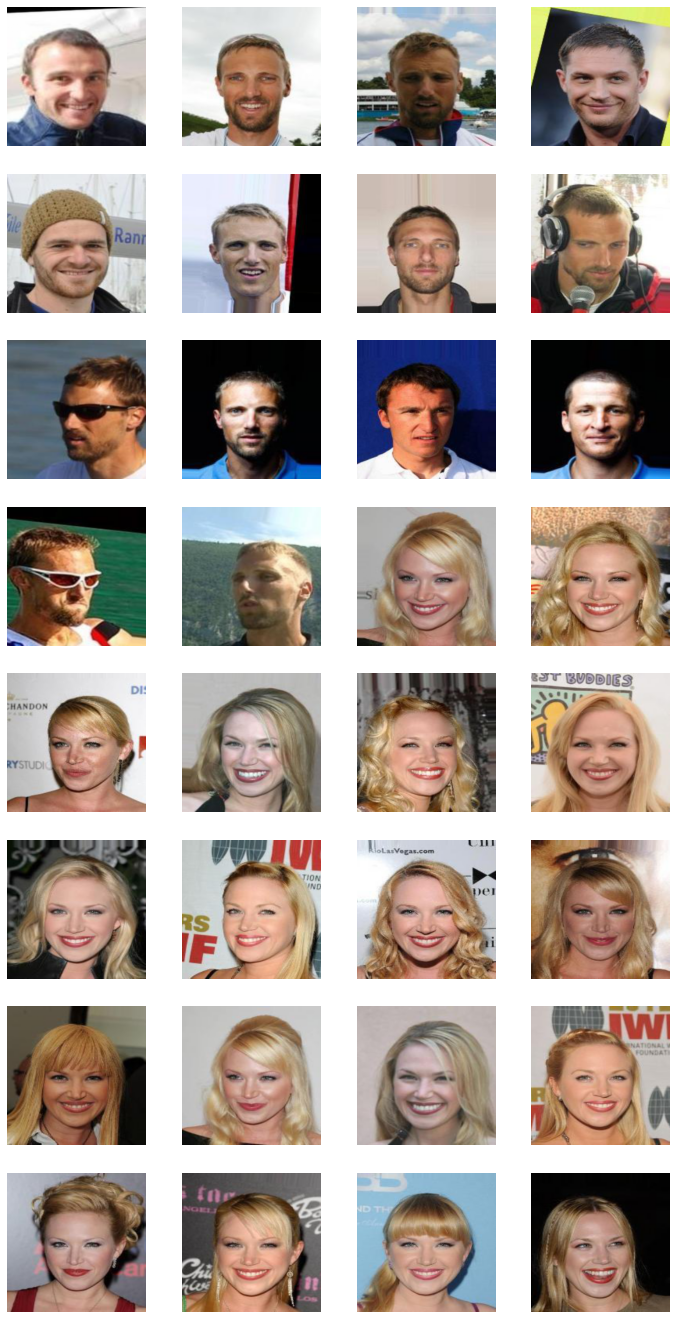

In [8]:
for i, (im, label) in enumerate(test_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

# Training the model

## Choosing the model

In [9]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary

cnn_model = CNN_MODEL_GROUP.MyCNN

if cnn_model == CNN_MODEL_GROUP.MyCNN:
    model_hparams = {
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 4,
        "filter_size": 3,
        "dropout": 0.00,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        'loss_margin': 5,
        'temperature': 10,
        'num_labeled_points_class': 2
    }
    
    scheduler_params = {
        "step_size": 5,
        "gamma": 0.5,
    }

# scheduler_params = None
freeze_layers = True

# num_classes = 10177
num_classes = 1000

model = Siamese_Group(hparams=model_hparams, 
                cnn_model = cnn_model, 
                freeze_layers = freeze_layers, 
                scheduler_params = scheduler_params,
                nb_classes = num_classes,
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()

print("Model input size", model.input_size)

Layers to update
	 conv.model.0.model.0.weight
	 conv.model.0.model.0.bias
	 conv.model.0.model.2.weight
	 conv.model.0.model.3.weight
	 conv.model.0.model.3.bias
	 conv.model.1.model.0.weight
	 conv.model.1.model.0.bias
	 conv.model.1.model.2.weight
	 conv.model.1.model.3.weight
	 conv.model.1.model.3.bias
	 conv.model.2.model.0.weight
	 conv.model.2.model.0.bias
	 conv.model.2.model.2.weight
	 conv.model.2.model.3.weight
	 conv.model.2.model.3.bias
	 linear.0.model.0.weight
	 linear.0.model.0.bias
	 linear.0.model.1.weight
	 linear.0.model.2.weight
	 linear.0.model.2.bias
	 linear.1.model.0.weight
	 linear.1.model.0.bias
	 linear.1.model.1.weight
	 linear.1.model.2.weight
	 linear.1.model.2.bias
	 classifier.weight
	 classifier.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 128, 128]             112
         MaxPool2d-2            [-1, 4, 64, 64]               

## Defining the Dataloader

In [10]:
print('len dataset', len(dataset))

num_classes_iter = 4
batch_size = 32


dataloader = CelebA_DataModule(name=DATASETS.CELEBA, 
                               nb_classes=num_classes, 
                               class_split=True, 
                               batch_size=batch_size, 
                               num_classes_iter=num_classes_iter, 
                               splitting_points=(0.20, 0.20), 
                               input_shape = (3, model.input_size, model.input_size),
                               num_workers = mp.cpu_count())

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

for i, batch in enumerate(train_loader):
    x, y = batch
    print(x.shape)
    break

len dataset 2234
split size 600 200 200
train classes 0 600
val classes 600 800
test classes 800 1000
Number of train batches 407
Number of valid batches 62
Number of test batches 66
torch.Size([32, 3, 128, 128])


In [11]:
# %tensorboard --logdir tb_logs

## Train Custom Model

In [12]:
exp_name = 'test_group_loss'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}',
    save_top_k=5,
    mode='min',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
#         early_stop_callback,
#         checkpoint_callback,
        lr_monitor,
    ],
    "fast_dev_run": False,
    "max_epochs": 3,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger('tb_group_logs', name=exp_name)

do_train = True

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | conv       | myCNN            | 1.6 K 
4 | linear     | Sequential       | 25.2 M
5 | classifier | Linear           | 2.0 M 


# Save/Load Checkpoint

## Manual Save

In [13]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved')  
    checkpoint_path = os.path.join(save_dir, 'Siamese-Contrastive-last.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing and use the checkpoints from group loss

In [14]:
load_checkpoint = False

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
#     checkpoint_path = os.path.join('data', 'checkpoint', 'margin5', 'Siamese-Contrastive-epoch=25-val_loss=1.00.ckpt')
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=12-val_loss=5.77.ckpt')
#     checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=13-val_loss=5.85.ckpt')

    
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
#     x1, x2, label, y = inference(chkpt_model, loader=dataloader.val_dataloader())
#     visualize_torch(x1[:5])
#     visualize_torch(x2[:5])
#     print("labels", label.squeeze()[:5])
#     print("predictions", y.squeeze()[:5])

## Retrain from checkpoint

In [15]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [16]:
trainer.test(model, dataloader.val_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(15.5503, device='cuda:0'),
 'avg_loss': tensor(18.2683, device='cuda:0'),
 'avg_nll_loss': tensor(2.7180, device='cuda:0'),
 'avg_recall@1': tensor(0.5701)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 18.268251419067383,
  'avg_recall@1': 0.5700604915618896,
  'avg_nll_loss': 2.7179834842681885,
  'avg_ce_loss': 15.550265312194824}]

### Note: Computational heavy!!!!

In [17]:
evaluate_nmi = False

In [18]:
from src.tools import evaluation_tool

if evaluate_nmi:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.val_dataloader())
    print('recall', recall)
    print('nmi', nmi)

## Run test epoch

In [19]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(15.5851, device='cuda:0'),
 'avg_loss': tensor(18.8740, device='cuda:0'),
 'avg_nll_loss': tensor(3.2889, device='cuda:0'),
 'avg_recall@1': tensor(0.8140)}
--------------------------------------------------------------------------------



[{'avg_loss': 18.873952865600586,
  'avg_recall@1': 0.8140121102333069,
  'avg_nll_loss': 3.2888600826263428,
  'avg_ce_loss': 15.585094451904297}]

### Note: Computational heavy!!!!

In [20]:
from src.tools import evaluation_tool

if evaluate_nmi:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.test_dataloader())
    print('recall', recall)
    print('nmi', nmi)

# Inference and Visualization

torch.Size([64, 3, 128, 128])
labels_0: 665 799 distance: 0.953
labels_1: 665 665 distance: 0.959
labels_2: 665 796 distance: 1.062
labels_3: 665 665 distance: 1.143
labels_4: 665 796 distance: 1.094
labels_5: 665 665 distance: 1.130


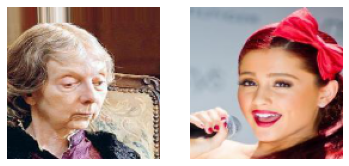

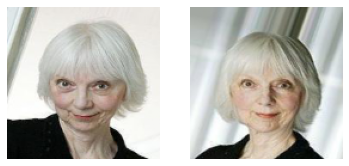

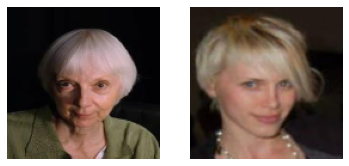

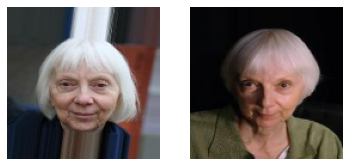

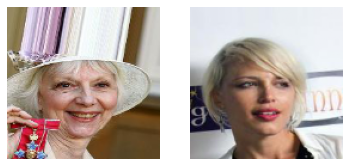

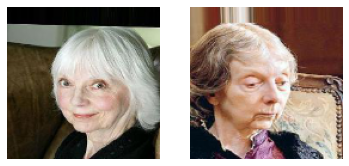

In [21]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.val_dataloader()):
    print(x.shape)
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        visualize_torch(img_matches, n_cols=2, n_rows=1)
        print(f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx]))
        if int(img_idx) == 5:
            break
    break


labels_0: 820 820 distance: 1.116
labels_1: 820 820 distance: 1.065
labels_2: 820 820 distance: 1.139
labels_3: 820 820 distance: 1.017
labels_4: 820 998 distance: 0.851
labels_5: 820 998 distance: 1.070


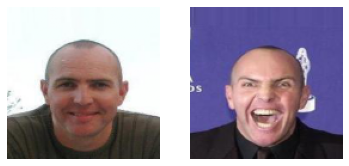

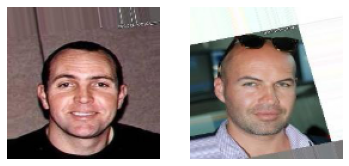

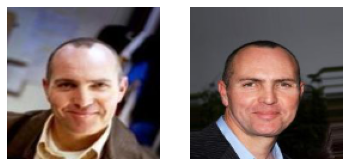

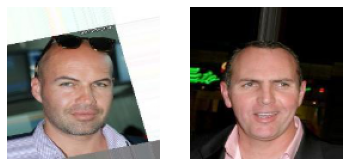

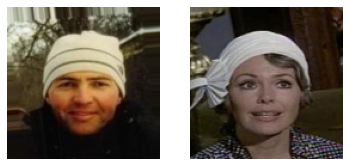

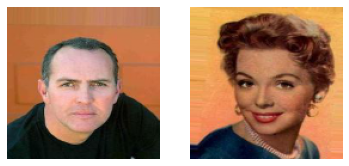

In [22]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.test_dataloader()):
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        visualize_torch(img_matches, n_cols=2, n_rows=1)
        print(f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx]))
        if int(img_idx) == 5:
            break
    break